In [1]:
import os
import cooler
import numpy as np
import pandas as pd
from scipy.stats import norm, zscore

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib import cm as cm
import seaborn as sns
from matplotlib.colors import LogNorm

from itertools import cycle, islice
import xarray as xr
from glob import glob

mpl.style.use('default')
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = 'Helvetica'


In [2]:
leg = ['L23_IT', 'L4_IT', 'L5_IT', 'L6_IT', 'L6_IT_Car3', 'L56_NP', 'L6_CT', 'L6b', 'L5_ET', 'Amy', 
       'Lamp5', 'Lamp5_LHX6', 'Sncg', 'Vip', 'Pvalb', 'Pvalb_ChC', 'Sst', 'CHD7', 
       'MSN_D1', 'MSN_D2', 'Foxp2', 'SubCtx', 
       'ASC', 'ODC', 'OPC', 'MGC', 'PC', 'EC', 'VLMC'
      ]
legname = ['L2/3-IT', 'L4-IT', 'L5-IT', 'L6-IT', 'L6-IT-Car3', 'L5/6-NP', 'L6-CT', 'L6b', 'L5-ET', 'Amy-Exc', 
       'Lamp5', 'Lamp5-Lhx6', 'Sncg', 'Vip', 'Pvalb', 'Pvalb-ChC', 'Sst', 'Chd7', 
       'MSN-D1', 'MSN-D2', 'Foxp2', 'SubCtx-Cplx', 
       'ASC', 'ODC', 'OPC', 'MGC', 'PC', 'EC', 'VLMC'
      ]
leg2name = {xx:yy for xx,yy in zip(leg, legname)}


In [3]:
leg = {'exc': ['L23_IT', 'L4_IT', 'L5_IT', 'L6_IT', 'L6_IT_Car3', 'L56_NP', 'L6_CT', 'L6b', 'Amy'], 
       'inh': ['Lamp5', 'Lamp5_LHX6', 'Sncg', 'Vip', 'Pvalb', 'Pvalb_ChC', 'Sst', 'CHD7'], 
       'msn': ['MSN_D1', 'MSN_D2', 'Foxp2'], 
       'sub': ['SubCtx'], 
       'glia': ['ASC', 'ODC', 'OPC'], 
       'mgc': ['MGC'], 
       'smc': ['PC'], 
       'endo': ['EC'], 
       'fibro': ['VLMC'],
      }
leg['neu'] = leg['exc'] + leg['inh'] + leg['msn'] + leg['sub']
leg['all'] = leg['neu'] + leg['glia'] + leg['mgc'] + leg['smc'] + leg['endo'] + leg['fibro']
leg['cge'] = ['Lamp5', 'Lamp5_LHX6', 'Sncg', 'Vip']


In [4]:
group_name = 'cge'

In [5]:
leg = pd.Index(leg[group_name])
legname = leg.map(leg2name)
res = 25000

In [6]:
indir = '/data/hba/domain_majortype/'
ddir = f'/home/jzhou_salk_edu/sky_workdir/hba/domain_majortype/diff/{group_name}/'
ldir = f'/home/jzhou_salk_edu/sky_workdir/hba/loop_majortype/diff/{group_name}/'
cdir = f'/home/jzhou_salk_edu/sky_workdir/hba/compartment_majortype/diff/{group_name}/'


In [7]:
chrom_size_path = '/home/jzhou_salk_edu/sky_workdir/hba/ref/hg38.main.chrom.sizes'
chrom_sizes = cooler.read_chromsizes(chrom_size_path, all_names=True)
chrom_sizes = chrom_sizes.iloc[:-3]


In [8]:
## Load boundary probability

bound_count_ct = pd.read_hdf(f'{indir}MajorType_boundcount.hdf', key='data').loc[leg]
cell_count_ct = pd.read_csv(f'{indir}MajorType_cellcount.csv.gz', index_col=0, header=0, squeeze=True).loc[leg]
bound_prob_ct = bound_count_ct / cell_count_ct[:,None]
bound_prob_ct


,chr1_0,chr1_1,chr1_2,chr1_3,chr1_4,chr1_5,chr1_6,chr1_7,chr1_8,chr1_9,...,chr22_2023,chr22_2024,chr22_2025,chr22_2026,chr22_2027,chr22_2028,chr22_2029,chr22_2030,chr22_2031,chr22_2032
Lamp5,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.076000,0.074000,0.084667,0.092667,0.083333,0.062667,0.039333,0.024000,0.033333,1.0
Lamp5_LHX6,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.075472,0.059119,0.069182,0.077987,0.091824,0.076730,0.031447,0.018868,0.038994,1.0
Sncg,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.071231,0.053942,0.085062,0.080221,0.081604,0.060166,0.034578,0.028354,0.032503,1.0
Vip,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.102000,0.061333,0.064000,0.055333,0.063333,0.052000,0.036667,0.022000,0.035333,1.0


In [9]:
## Load insulation score

ins_count = xr.open_dataset(f'{indir}MajorType_impute.insulation.nc')
ins_count = ins_count.sel({'bin': (ins_count['bin_chrom']!='chrX')})
ins_count['ratio'] = (ins_count.sel({'type':'inter'})['__xarray_dataarray_variable__'] / ins_count.sel({'type':'intra'}))['__xarray_dataarray_variable__']
ins = ins_count['ratio'].to_pandas().loc[leg]


In [10]:
genemeta = pd.read_csv('/home/jzhou_salk_edu/sky_workdir/hba/ref/gencode.v33.bed', sep='\t', header=None, index_col=4)
genemeta = genemeta[~genemeta.index.duplicated(keep='first')]


In [11]:
gtmp = 'LAMP5'
lslop, rslop = 1000000, 2000000

chrom = genemeta.loc[gtmp, 0]
if genemeta.loc[gtmp, 5]=='+':
    tss = genemeta.loc[gtmp, 1]
    tes = genemeta.loc[gtmp, 2]
else:
    tss = genemeta.loc[gtmp, 2]
    tes = genemeta.loc[gtmp, 1]

ll, rr = (tss - lslop), (tss + rslop)
print(chrom, ll, rr, genemeta.loc[gtmp, 5])


chr20 8514358 11514358 +


In [12]:
## contact maps are plotted at loop resolution
## select region to plot in Q matrix

resl = 10000
loopl, loopr = (ll//resl), (rr//resl)
print(loopl, loopr)


851 1151


In [13]:
indir = '/home/jzhou_salk_edu/sky_workdir/hba/loop_majortype/'

In [14]:
## Load cell type Q

from scipy import ndimage as nd

dstall = []
for ct in leg:
    cool = cooler.Cooler(f'{indir}{ct}/{ct}/{ct}.Q.cool')
    Q = cool.matrix(balance=False, sparse=True).fetch(chrom).tocsr()
    tmp = Q[loopl:loopr, loopl:loopr].toarray()
    dstall.append(tmp)
    print(ct)


Lamp5
Lamp5_LHX6
Sncg
Vip


In [15]:
## select differential loop

loopall = pd.read_hdf(f'{ldir}merged_loop.hdf', key='data')
sell = ((loopall[0]==chrom) & 
        (zscore(np.log(loopall['Qanova']))>norm.isf(0.15)) & 
        (zscore(np.log(loopall['Tanova']))>norm.isf(0.15)) & 
        (loopall[1]>ll) & (loopall[5]<rr))


In [16]:
## select differential boundary

binall = pd.read_hdf(f'{ddir}MajorType_boundary_stats.hdf', key='data')
selb = (binall['chrom']==chrom) & (binall['start']>=ll) & (binall['start']<rr) & binall['bklfilter'] & binall['chi2filter'] & binall['ins_lm'] & (binall['probdiff']>0.05) & binall['diff_sc']
print(selb.sum())


3


In [17]:
ins.columns = binall.index

In [18]:
## select differential compartment

resc = 100000
comp = pd.read_csv(f'{cdir}DifferentialResult/fdr_result/differential.intra_sample_combined.pcQnm.bedGraph', sep='\t', header=0, index_col=None)
comp.index = comp['chr'] + '_' + (comp['start'] // resc).astype(str)
bincomp = comp[['chr', 'start', 'end', 'sample_maha', 'pval', 'padj']]
comp = comp[leg]
selc = (bincomp['chr']==chrom) & (bincomp['start']>=ll) & (bincomp['start']<rr) & (zscore(bincomp['sample_maha'])>norm.isf(0.025))
print(selc.sum())


0


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica


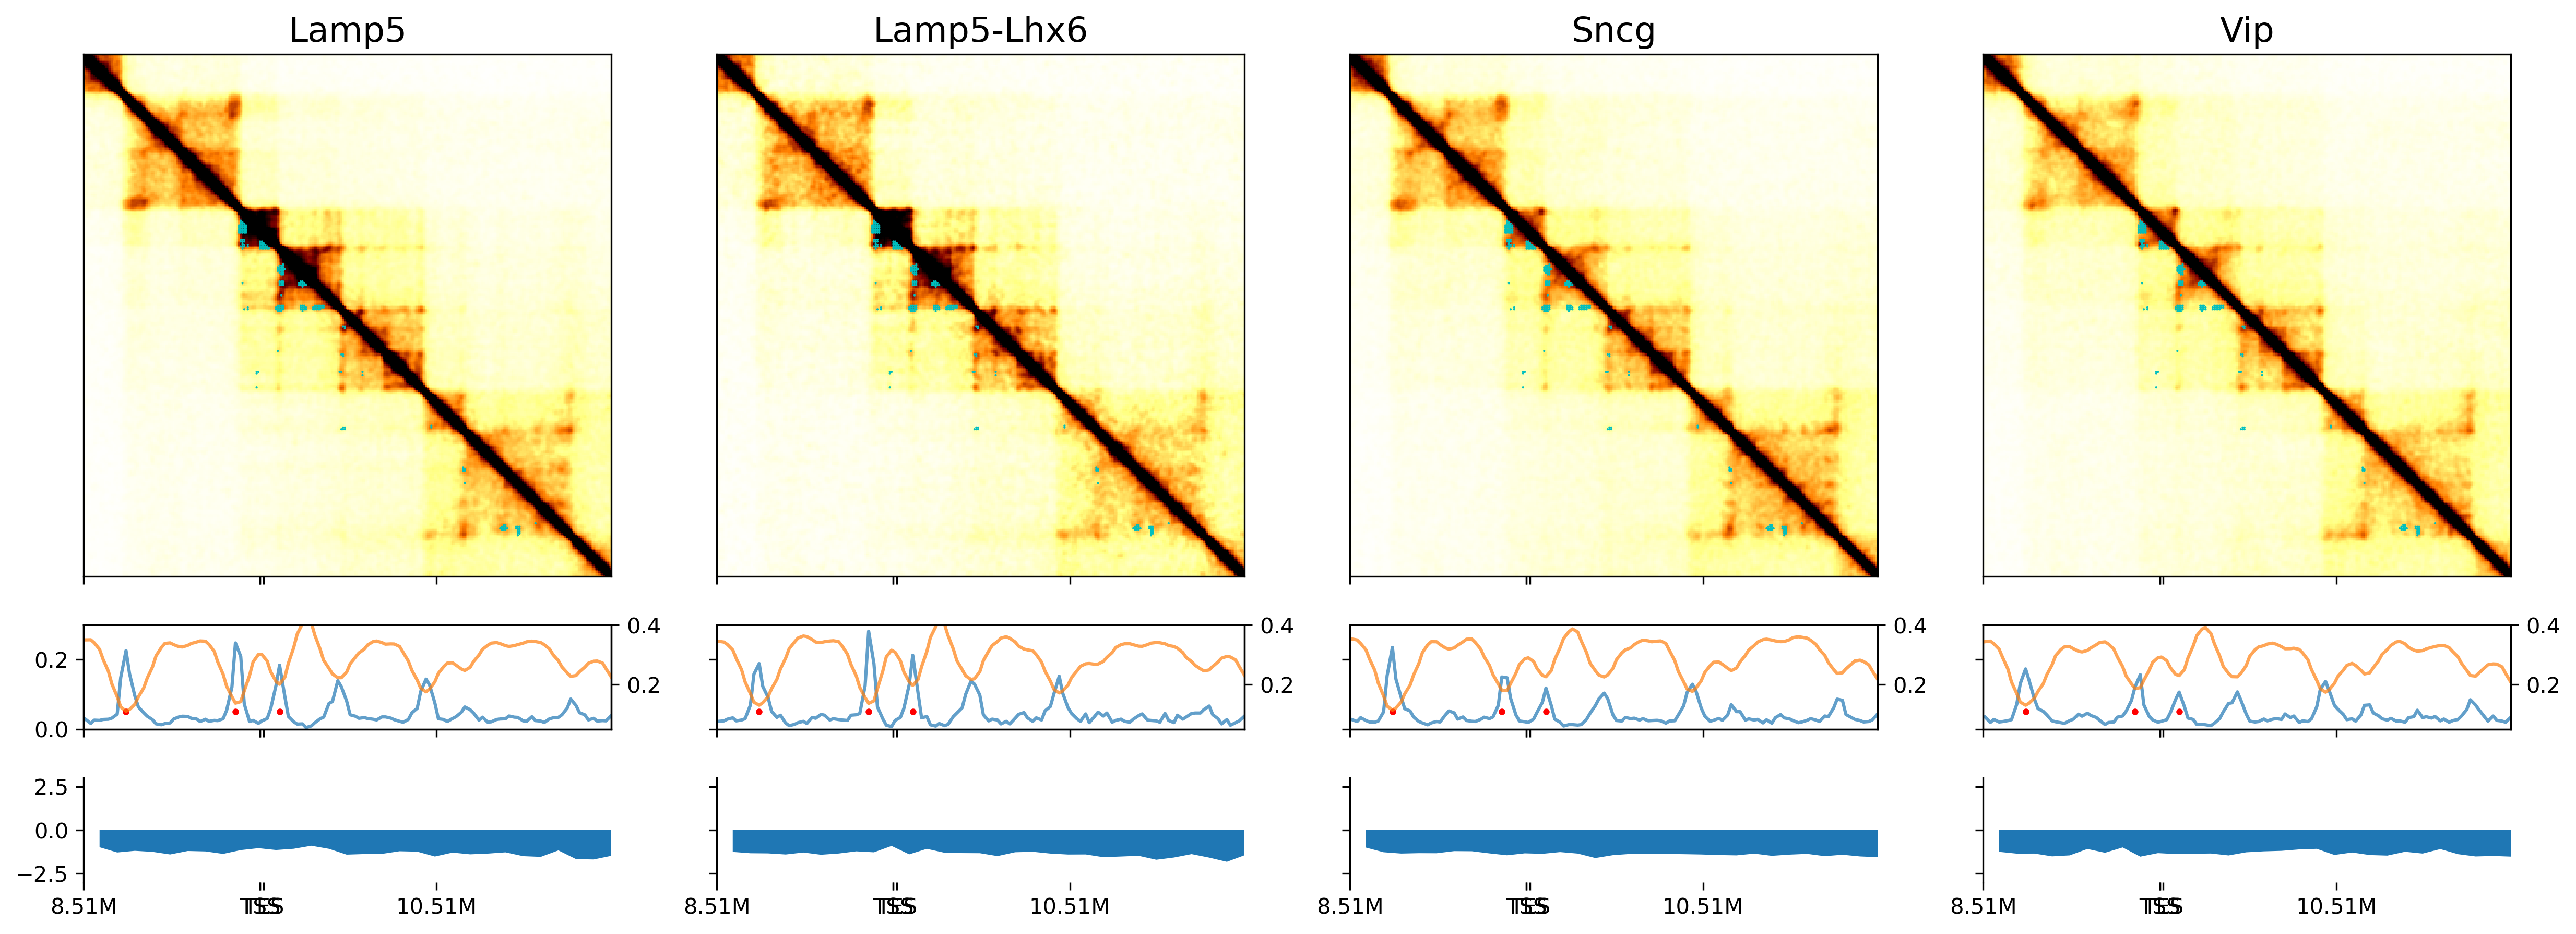

In [19]:
fig, axes = plt.subplots(3, len(leg), figsize=(5*len(leg), 7), sharex='col', sharey='row',
                         gridspec_kw={'height_ratios':[5,1,1]}, dpi=300)

## differential feature position
tmpl = loopall.loc[sell, [1,4]].values // resl - loopl
tmpd = binall.loc[selb, 'start'] // resl - loopl
tmpc = bincomp.loc[selc, 'start'] // resl - loopl

for i in range(len(leg)):
    ax = axes[0,i]
    ax.axis('equal')
    ax.set_title(legname[i], fontsize=16)
    img = ax.imshow(dstall[i], cmap='afmhot_r', vmin=0, vmax=0.012, aspect='auto')
    ax.set_yticks([])
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.scatter(tmpl[:, 0], tmpl[:, 1], alpha=1, s=1, marker='o', edgecolors='none', color='c')

    ax = axes[1,i]
    ## plot boundary prob
    sel = (binall['chrom']==chrom) & (binall['start']>=ll) & (binall['start']<rr)
    ax.plot(binall.loc[sel, 'start'] // resl - loopl, 
            bound_prob_ct.loc[leg[i], sel].values, 
            c='C0', alpha=0.7)
    ax.scatter(tmpd, np.zeros(len(tmpd))+0.05, color='r', s=4)
    ax.set_ylim([0, 0.3])
    ax2 = ax.twinx()
    ## plot insulation score
    ax2.plot(binall.loc[sel, 'start'] // resl - loopl, 
             ins.loc[leg[i], sel].values, 
             c='C1', alpha=0.7)
    ax2.set_ylim([0.05, 0.4])
    ax.set_xlim([0, loopr-loopl-1])
    ax.set_xticks(np.arange(0, loopr-loopl+1, 100).tolist() + [tss//resl-loopl, tes//resl-loopl])
    ax.set_xticklabels([])
    
    ax = axes[2,i]
    sns.despine(bottom=True, ax=ax)
    ## plot compartment
    sel = (bincomp['chr']==chrom) & (bincomp['start']>=ll) & (bincomp['start']<rr)
    x = bincomp.loc[sel, 'start'] // resl - loopl
    y = comp.loc[sel, leg[i]].values
    ax.fill_between(x, y, 0, where=y >= 0, facecolor='C3', interpolate=True)
    ax.fill_between(x, y, 0, where=y <= 0, facecolor='C0', interpolate=True)
    ax.scatter(tmpc, np.zeros(len(tmpc)), color='r', s=4)
    ax.set_ylim([-3, 3])
    ax.set_xlim([0, loopr-loopl-1])
    ax.set_xticks(np.arange(0, loopr-loopl, 100).tolist() + [tss//resl-loopl, tes//resl-loopl])
    ax.set_xticklabels([])
    ax.set_xticklabels([f'{(xx+loopl)/100}M' for xx in np.arange(0, loopr-loopl, 100)]+['TSS','TES'])

# plt.savefig(f'{group_name}_diff_{gtmp}.pdf', transparent=True, dpi=300)



In [20]:
dstall = []
for ct in leg:
    cool = cooler.Cooler(f'{indir}{ct}/{ct}/{ct}.Q.cool')
    Q = cool.matrix(balance=False, sparse=True).fetch(chrom).tocsr()
    tmp = Q[loopl:loopr, loopl:loopr].toarray()
    dst = nd.rotate(tmp, 45, order=0, reshape=True, prefilter=False, cval=0)
    dstall.append(dst)
    print(ct)


Lamp5
Lamp5_LHX6
Sncg
Vip


[Text(0.0, 0, '8.51M'),
 Text(141.4213562373095, 0, 'TSS'),
 Text(282.842712474619, 0, '10.51M'),
 Text(424.26406871192853, 0, '11.51M'),
 Text(141.4213562373095, 0, 'TSS'),
 Text(144.2497833620557, 0, 'TES')]

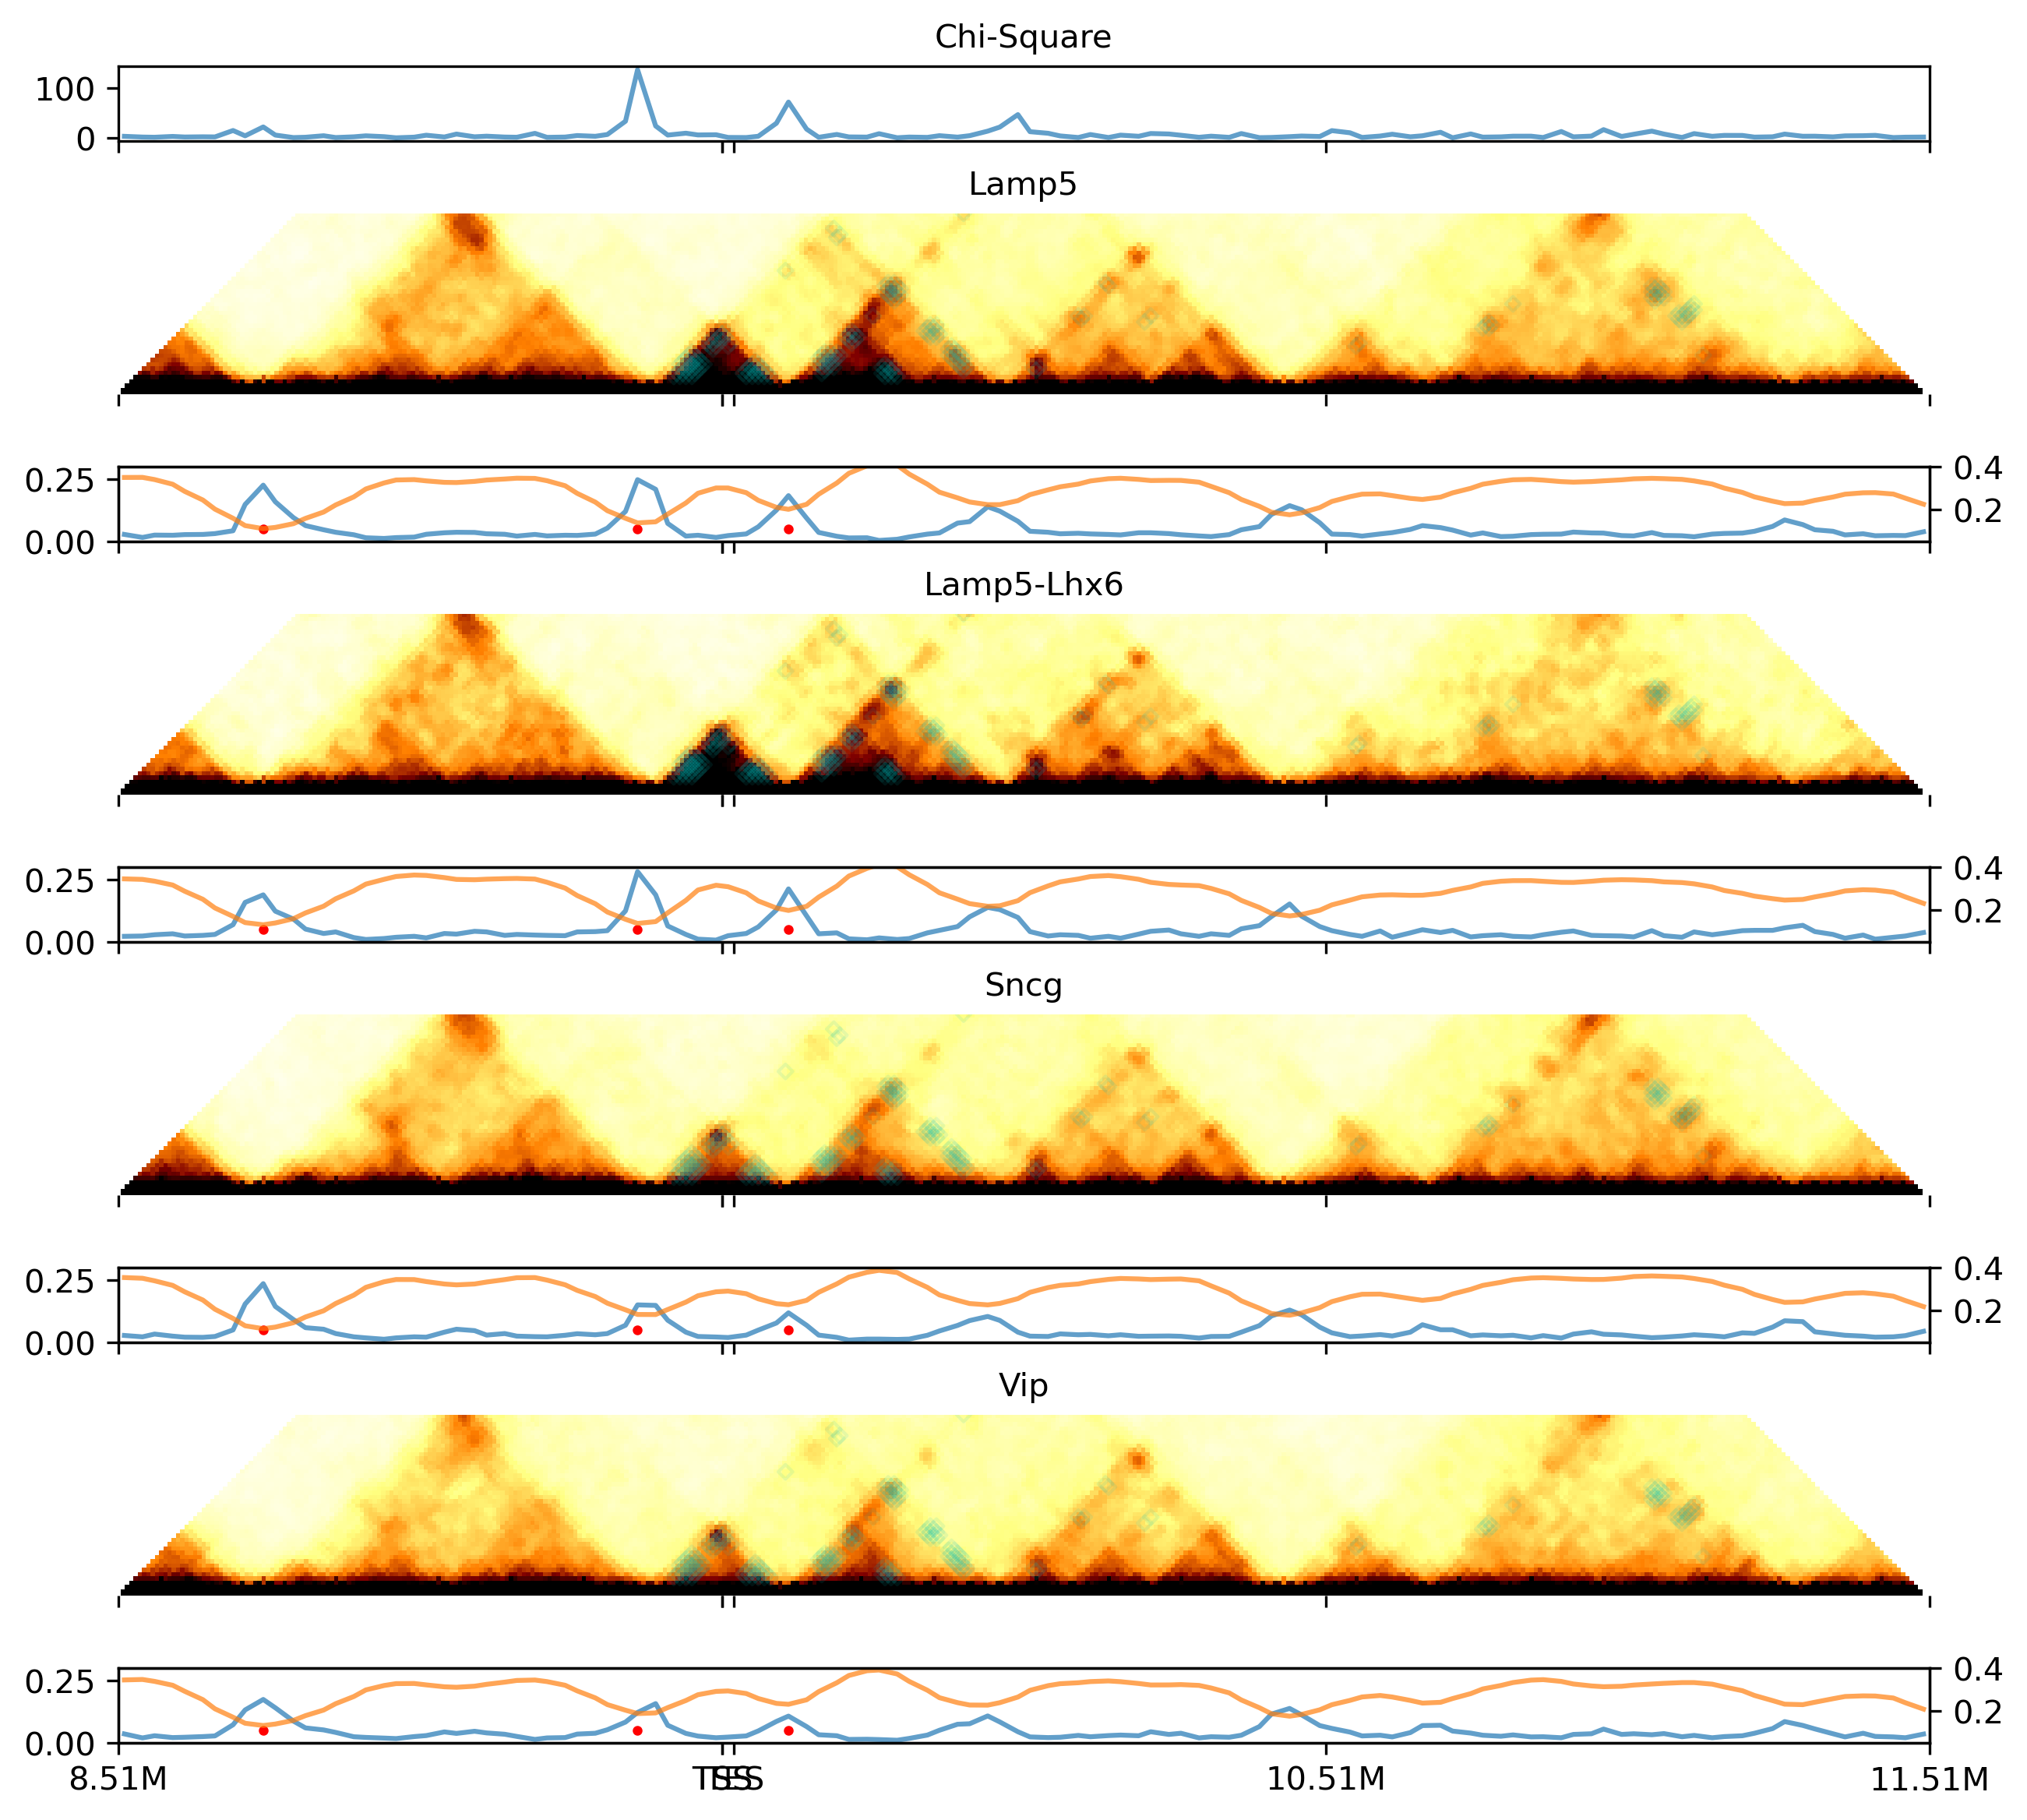

In [21]:
fig, axes = plt.subplots(len(leg)*2+1, 1, figsize=(10, np.sum([1] + np.tile([3.5,1],len(leg)).tolist())/2), 
                         gridspec_kw={'height_ratios':[1] + np.tile([3.5,1],len(leg)).tolist()}, dpi=300, sharex='all')

tmpl = loopall.loc[sell, [1,4]].values // resl - loopl
tmpd = binall.loc[selb, 'start'] // resl - loopl
tmpc = bincomp.loc[selc, 'start'] // resl - loopl

ax = axes[0]
sel = (binall['chrom']==chrom) & (binall['start']>=ll) & (binall['start']<rr)
xpos = (binall.loc[sel, 'start'] // resl - loopl) * np.sqrt(2)
ax.plot(xpos, binall.loc[sel, 'chi2_sc'].values, 
        c='C0', alpha=0.7)

ax.set_title('Chi-Square', fontsize=10)
ax.set_xlim([0, (loopr-loopl-1)*np.sqrt(2)])

for i in range(len(leg)):
    ax = axes[i*2+1]
    ax.set_title(legname[i], fontsize=10)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    img = ax.imshow(dstall[i], cmap='afmhot_r', vmin=0, vmax=0.012)
    h = len(dstall[i])
    ax.set_ylim([0.5*h, 0.4*h])
    ax.set_xlim([0, h])
    ax.set_yticks([])
    ax.set_yticklabels([])
    ax.scatter((tmpl[:, 0]+tmpl[:, 1])/np.sqrt(2), 0.5*h-(tmpl[:, 1]-tmpl[:, 0])/np.sqrt(2), 
           alpha=0.1, s=10, marker='D', edgecolors='c', color='none')

    ax = axes[i*2+2]
    ax.plot(xpos, bound_prob_ct.loc[leg[i], sel].values, c='C0', alpha=0.7)
    ax.scatter(tmpd * np.sqrt(2), np.zeros(len(tmpd))+0.05, color='r', s=4)
    ax.set_ylim([0, 0.3])
    ax2 = ax.twinx()
    ax2.plot(xpos, ins.loc[leg[i], sel].values, c='C1', alpha=0.7)
    ax2.set_ylim([0.05, 0.4])
    
ax.set_xlim([0, (loopr-loopl-1)*np.sqrt(2)])
ax.set_xticks(np.sqrt(2)*np.array(np.arange(0, loopr-loopl+1, 100).tolist() + [tss//resl-loopl, tes//resl-loopl]))
ax.set_xticklabels([])
ax.set_xticklabels([f'{(xx+loopl)/100}M' for xx in np.arange(0, loopr-loopl+1, 100)]+['TSS','TES'])

# plt.savefig(f'/gale/netapp/entex/HBA/snm3C/plot/majortype_diff_FOXP2.pdf', transparent=True, dpi=300)

